In [1]:
from trainer import Trainer 
import torch
import validate
from transformer.utils import subsequent_mask
import matplotlib.pyplot as plt
import seaborn
from dataset.iwslt import IWSLTDatasetBuilder

### Load model and vocabularies

In [2]:

max_length=40
params = {
    "training": {
        "epochs": 1,
        "train_batch_size": 1024,
        "valid_batch_size": 1024,
        "smoothing": 0.1,
        "save_intermediate": False,
        "multi_gpu": False,
        "load_trained_model": False,
        "trained_model_checkpoint": ""
    },

    "optim": {
        "lr": 0.,
        "betas": (0.9, 0.98),
        "eps": 1e-9,
        "factor": 1,
        "warmup": 2000

    },

    "dataset": {
        "max_seq_length": max_length,  # ~ 90% of the training set
        "min_freq": 2,
        "start_token": "<s>",
        "eos_token": "</s>",
        "pad_token": "<blank>"

    },

    "model": {
        'd_model': 512,
        'N': 6,
        'dropout': 0.1,

        'attention': {
            'n_head': 8,
            'd_k': 64,
            'd_v': 64,
            'dropout': 0.1},

        'feed-forward': {
            'd_ff': 2048,
            'dropout': 0.1}
    }
}
trainer_ = Trainer(params)

[2019-04-20 19:10:31] - INFO - Trainer >>> Folder experiments/IWSLT/20190420_191031/ created.
[2019-04-20 19:10:31] - INFO - Trainer >>> Log File experiments/IWSLT/20190420_191031/training.log created.
[2019-04-20 19:10:31] - INFO - Trainer >>> Model folder experiments/IWSLT/20190420_191031/models/ created.
[2019-04-20 19:10:31] - INFO - Trainer >>> Configuration saved to experiments/IWSLT/20190420_191031/params.json.
[2019-04-20 19:10:31] - INFO - root >>> Failed to import cuda module: No module named 'caffe2.python.caffe2_pybind11_state_gpu'
[2019-04-20 19:10:31] - INFO - root >>> Failed to import AMD hip module: No module named 'caffe2.python.caffe2_pybind11_state_hip'
[2019-04-20 19:10:31] - WARNING - root >>> This caffe2 python run does not have GPU support. Will run in CPU only mode.
[2019-04-20 19:10:31] - INFO - Trainer >>> Creating the training & validation dataset, may take some time...
downloading fr-en.tgz


fr-en.tgz: 100%|██████████| 25.7M/25.7M [01:12<00:00, 354kB/s] 


resources/torchtext/iwslt/fr-en/IWSLT16.TED.dev2010.fr-en.en.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.dev2010.fr-en.fr.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2010.fr-en.en.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2010.fr-en.fr.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2011.fr-en.en.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2011.fr-en.fr.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2012.fr-en.en.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2012.fr-en.fr.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2013.fr-en.en.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2013.fr-en.fr.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2014.fr-en.en.xml
resources/torchtext/iwslt/fr-en/IWSLT16.TED.tst2014.fr-en.fr.xml
resources/torchtext/iwslt/fr-en/train.tags.fr-en.en
resources/torchtext/iwslt/fr-en/train.tags.fr-en.fr
[2019-04-20 19:13:36] - INFO - Trainer >>> Created a training & a validation dataset, with src_vocab_size=46149 and 

In [3]:
model, src_vocab, trg_vocab = trainer_.model, trainer_.src_vocab, trainer_.trg_vocab

In [4]:
word = 0
batch = next(IWSLTDatasetBuilder.masked(IWSLTDatasetBuilder.transposed(
                        trainer_.training_dataset_iterator)))
src_, trg_ = batch.src[0], batch.trg[0]

In [5]:
source = [src_vocab.itos[token] for token in src_] # french version
target = [trg_vocab.itos[token] for token in trg_] # english version
print(f'Source French sentence:\n {source}')
print(f'\nTarget English sentence:\n{target}')

Source French sentence:
 ['<unk>', 'ans', 'plus', 'tard', ',', 'on', 'dirait', 'plutôt', "l'inverse", ':', '«', '<unk>', 'davantage', 'de', 'ces', 'machines', ',', 'elles', 'travaillent', 'comme', 'des', 'Allemands', '.', '»', 'La', 'technologie', 'va', 'remplacer', 'beaucoup', "d'emplois", ',', 'des', 'emplois', 'ordinaires', '.', '<blank>', '<blank>', '<blank>', '<blank>', '<blank>']

Target English sentence:
['<s>', 'Sixteen', 'years', 'later', ',', 'you', "'d", 'probably', 'say', 'the', 'opposite', '.', '``', 'Send', 'me', 'more', 'of', 'these', 'machines', '.', 'They', 'work', 'like', 'Germans', '.', "''", 'Technology', 'will', 'replace', 'a', 'lot', 'of', 'jobs', ',', 'regular', 'jobs', '.', '</s>', '<blank>', '<blank>', '<blank>']


#### Greedy Decoder

In [6]:
model.eval()
start_symbol ="<s>"
stop_symbol="</s>"
blank_symbol = "<blank>"

sent = source
src = torch.LongTensor([[src_vocab.stoi[w] for w in sent]])
src_mask = (src != src_vocab.stoi[blank_symbol]).unsqueeze(-2)
src_mask

tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]],
       dtype=torch.uint8)

In [7]:
# 1. Embedding src
embedded = model.src_embeddings(src.type(torch.LongTensor))
embedded.shape

torch.Size([1, 40, 512])

In [8]:
# 2. Encode embedded inputs
memory = model.encoder(src=embedded, mask=src_mask)
memory.shape

torch.Size([1, 40, 512])

In [9]:
# 3. Create initial input for decoder
decoder_in = torch.ones(src.shape[0], 1).type(torch.FloatTensor) * trg_vocab.stoi[start_symbol]
decoder_in

tensor([[2.]])

In [10]:
logits = []
## decode each word one by one considering previous output
for i in range(max_length):
    # 4. Embed decoder_in
    decoder_in_embed = model.trg_embeddings(decoder_in.type(torch.LongTensor))

    # 5. Go through decoder
    out = model.decoder(x=decoder_in_embed, memory=memory,
                       self_mask=subsequent_mask(decoder_in.shape[1]),
                       memory_mask=src_mask)

    # 6. classifier: TODO: Why only last word?
    logits.append(model.classifier(out[:, -1]))

    # 7. Get predicted token for each sample in the batch
    _, next_token = logits[-1].max(dim=1, keepdim=True)

    # 8. Concatenate predicted token with previous predictions
    decoder_in = torch.cat([decoder_in, next_token.type(torch.FloatTensor)], dim=1)

In [11]:
# cast to int tensors
decoder_in = decoder_in.type(torch.IntTensor)

In [12]:
# 9. retrieve words from tokens in the target vocab
translation = ""
for i in range( decoder_in.shape[1]):
    sym = trg_vocab.itos[decoder_in[0, i]]
    translation += sym + " "

    if sym == trg_vocab.stoi[stop_symbol]:
        break

# 10. return prediction
translation

'<s> slavery slavery slavery slavery slavery slavery slavery slavery slavery slavery slavery slavery slavery slavery slavery slavery slavery significance slavery slavery significance slavery significance significance significance significance significance significance significance significance significance significance significance significance significance significance significance significance significance significance '

### Access the attention on encoder layer

In [16]:
n_head= 8
layer = 1
h =4

In [17]:
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

In [18]:
model.encoder.layers[layer].self_attention.attention.attention_weights[0, h].shape

torch.Size([40, 40])

#### First 4 head on each stack
##### 4 first heads on each stack. Attention of source with respect to source

Encoder stack 1


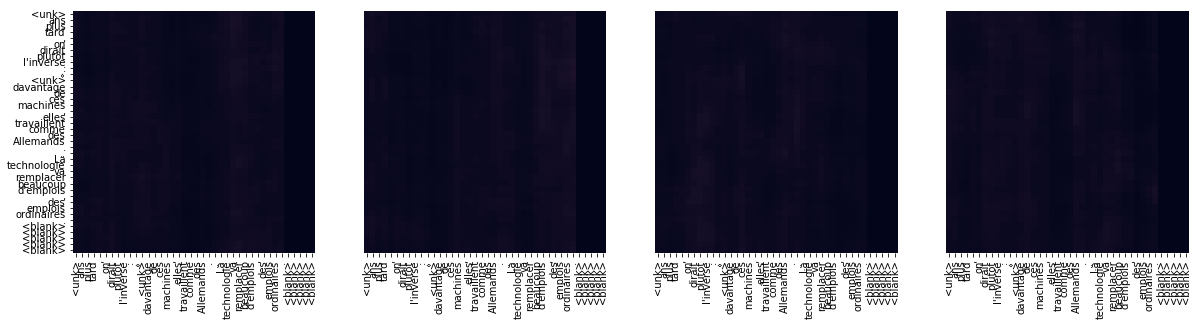

Encoder stack 2


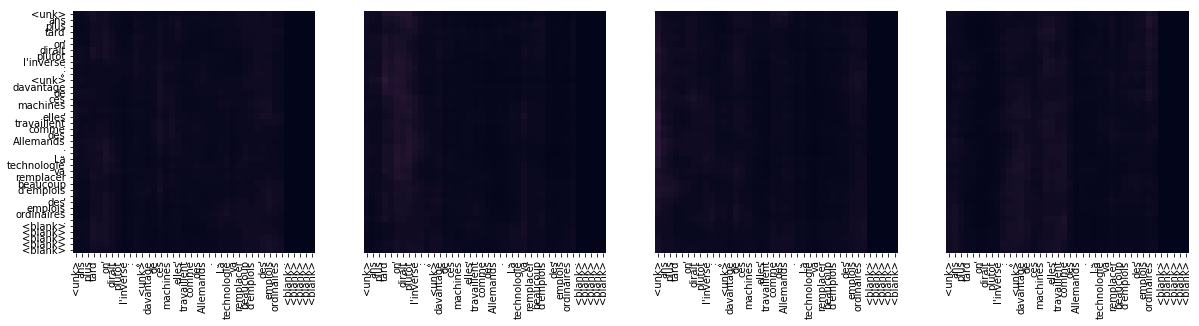

Encoder stack 3


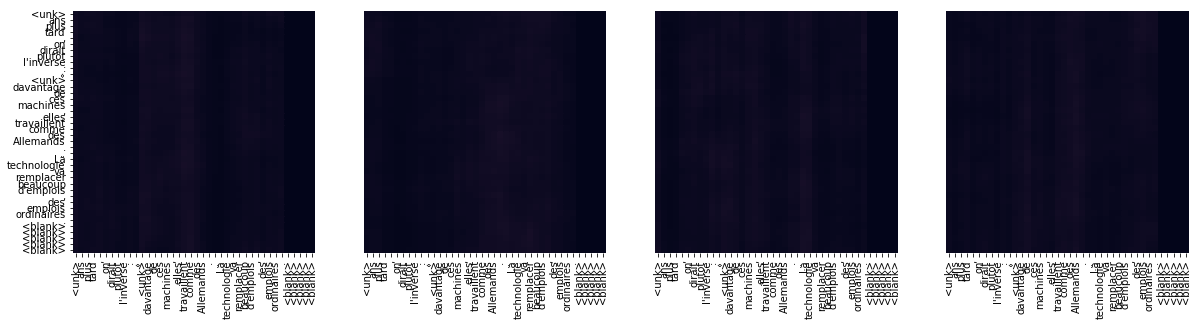

Encoder stack 4


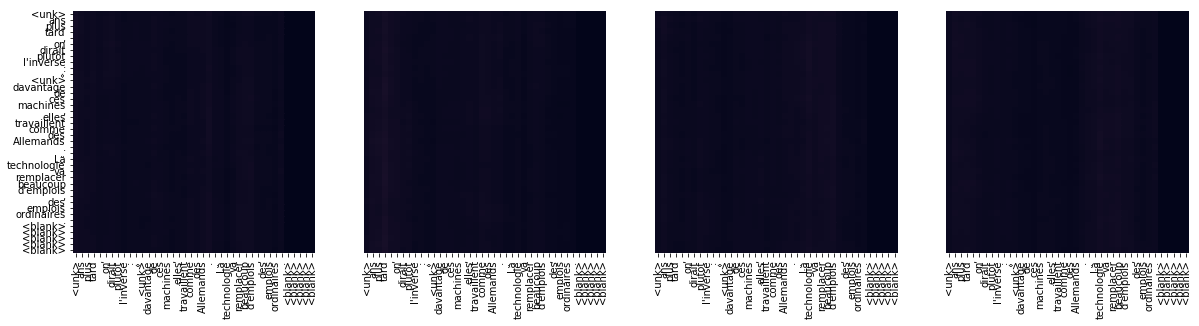

Encoder stack 5


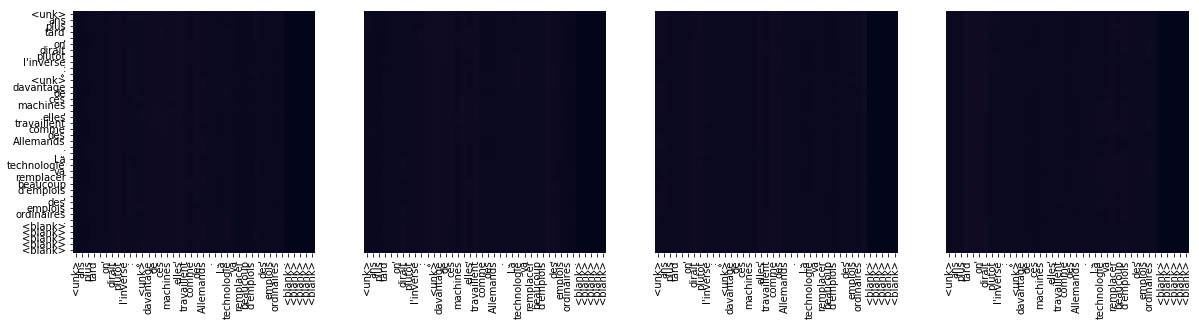

Encoder stack 6


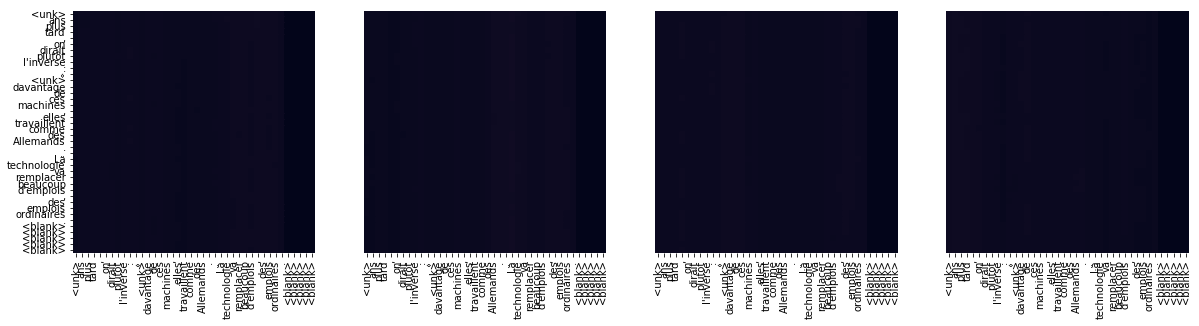

In [19]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Encoder stack", layer+1)
    for h in range(0, int(n_head/2)):
        draw(model.encoder.layers[layer].self_attention.attention.attention_weights[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

#### Prepare the json file for netviz

In [20]:
layer = 1
h = 4
attention = model.encoder.layers[layer].self_attention.attention.attention_weights[0, h].data
posterior =  list(logits.view(-1).data.numpy())

AttributeError: 'list' object has no attribute 'view'

In [ ]:
model.decoder.layers[layer]


In [ ]:
model.decoder.layers[layer].memory_attn.attention.attention_weights[0, h].data.numpy().shape
len(target)

In [ ]:
for i in range(len(source)):
    json_src = {
    "text": source,
    "label": target[1],
    "prediction": translation.split()[i],
    "posterior": list(logits[1].view(-1).data.numpy()),
    "attention": list(model.decoder.layers[layer].memory_attn.attention.attention_weights[0, h, i].data.numpy()),
    "id": "sample_55"
  }

In [ ]:
json_src